Download links:
- BDIFF : https://bdiff.agriculture.gouv.fr

# Method :

1. GeoParsing using https://github.com/ArthurCalvi/GeoParsing 
2. Joining with BDFORET for retrieving tree species

In [1]:
import geopandas as gpd
epsg = 'epsg:2154'
gdf = gpd.read_parquet('../data/processed_datasets/bdiff_2012_2022_FR_EPSG4326.parquet').to_crs(epsg)

<Axes: >

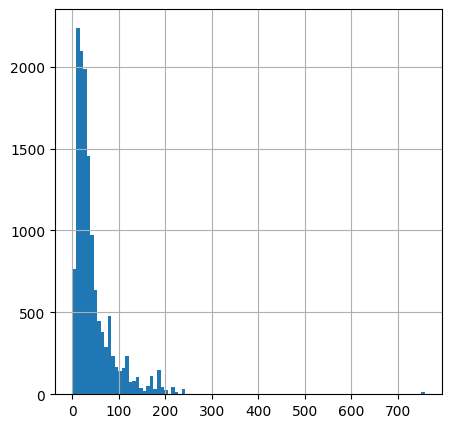

In [3]:
(gdf.geometry.area / 10**6).hist(bins=100, figsize=(5, 5))

In [2]:
bdforet30 = gpd.read_parquet('../data/processed_datasets/BDFORET_EPSG2154_FR_simplified30.parquet')

In [3]:
import pandas as pd
import numpy as np

def get_tree_species(row):

    index = bdforet30.sindex.query(row.geometry, predicate='intersects')
    if len(index) == 1:
        index = index[0]
        return bdforet30.iloc[index][['tree_type', 'essence']]
    elif len(index) > 1:
        sub = bdforet30.iloc[index]
        if len(sub.tree_type.unique().tolist()) > 1:
            tree_type = 'Mixed' 
        else : 
            tree_type = sub.tree_type.iloc[0] if type(sub.tree_type.iloc[0]) == str else np.nan 
        essence = ",".join([x for x in sub.essence.unique().tolist() if type(x) == str and x not in ['nr', 'none']])
        #put in a pandas series with tree_type and essence as row names
        return pd.Series([tree_type, essence], index=['tree_type', 'essence'])
    else :
        return None, None



In [4]:
gdf[['tree_type', 'essence']] = gdf.apply(get_tree_species, axis=1, result_type='expand')

In [15]:
gdf.to_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet')